# 1. Business understanding

# 2. Data Understanding

In [2]:
!pip install --upgrade --no-deps seaborn pandas

    100% |################################| 215kB 5.0MB/s eta 0:00:01
    100% |################################| 10.0MB 1.7MB/s eta 0:00:01


In [2]:
# The code was removed by Watson Studio for sharing.

Let's start by importing the data and having a look at some of the rows

In [3]:
user_log = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-sfbydsmsmr0lxg'),)
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
nrows = user_log.count()
print('Number of rows: {}'.format(nrows))

Number of rows: 543705


In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
ncols = len(user_log.columns)
print('Number of columns: {}'.format(ncols))

Number of columns: 18


In [7]:
num_vars = []
char_vars = []
for var, var_type in user_log.dtypes:
    if var_type == 'string':
        char_vars.append(var)
    else:
        num_vars.append(var)

In [8]:
num_vars

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [9]:
char_vars

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [10]:
summary_stats = user_log.describe(*num_vars)

In [11]:
summary_stats.toPandas()

,summary,itemInSession,length,registration,sessionId,status,ts
0,count,543705,432877,528005,543705,543705,543705
1,mean,107.30629109535502,248.6645927800741,1.5355234148639534E12,2040.8143533717732,210.01829116892432,1.5409645412097434E12
2,stddev,116.72350849188166,98.41266955052022,3.078725492996257E9,1434.3389310782668,31.471919021567206,1.4820571449120324E9
3,min,0,0.78322,1509854193000,1,200,1538352011000
4,max,1005,3024.66567,1543073874000,4808,404,1543622466000


In [12]:
eval_char_vars = ['artist',
 'auth',
 'gender',
 'level',
 'method',
 'page',
 'song',
 'userAgent']

In [13]:
for var in eval_char_vars:
    count_var = 'count('+ var + ')'
    (user_log.groupBy(var)
                .agg(F.count('userId').alias('count'))
                .sort(F.desc('count'))).show(truncate=False)

+----------------------+------+
|artist                |count |
+----------------------+------+
|null                  |110828|
|Kings Of Leon         |3497  |
|Coldplay              |3439  |
|Florence + The Machine|2314  |
|Muse                  |2194  |
|Dwight Yoakam         |2187  |
|The Black Keys        |2160  |
|BjÃÂ¶rk              |2150  |
|Justin Bieber         |2096  |
|Jack Johnson          |2049  |
|Radiohead             |1694  |
|Eminem                |1686  |
|Alliance Ethnik       |1654  |
|OneRepublic           |1651  |
|Taylor Swift          |1555  |
|The Killers           |1554  |
|Train                 |1537  |
|Linkin Park           |1487  |
|Evanescence           |1426  |
|John Mayer            |1350  |
+----------------------+------+
only showing top 20 rows

+----------+------+
|auth      |count |
+----------+------+
|Logged In |527906|
|Logged Out|15606 |
|Cancelled |99    |
|Guest     |94    |
+----------+------+

+------+------+
|gender|count |
+------+-----

In [14]:
distinct_number_users = user_log.select('userId').distinct().count()
print('Distinct Number of users: {}'.format(distinct_number_users))

Distinct Number of users: 449


In [15]:
# Drop unneccessary columns
user_log = user_log.drop(*['firstName','lastName','Artist','song'])

In [16]:
user_log = user_log.withColumn('ts', ((F.col('ts')/ 1000.0).cast("timestamp")))
user_log = user_log.withColumn("date", F.to_date(F.col("ts")))
user_log = user_log.withColumn('registration', ((F.col('registration')/ 1000.0).cast("timestamp")))
user_log = user_log.withColumn('registration_date', F.to_date(F.col("registration")))

In [17]:
user_log.agg(F.min('date'), F.max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-01|
+----------+----------+



In [18]:
user_log.agg(F.min('registration_date'), F.max('registration_date')).show()

+----------------------+----------------------+
|min(registration_date)|max(registration_date)|
+----------------------+----------------------+
|            2017-11-05|            2018-11-24|
+----------------------+----------------------+



In [19]:
user_log = user_log.withColumn('Churned', (F.when(F.col("page").isin(['Submit Downgrade','Cancel']) , 1)
                                           .otherwise(0)))

In [20]:
churn_by_user =user_log.groupBy('userId').agg(F.max('Churned').alias('Churned'))

In [21]:
churn_rate = churn_by_user.agg(F.mean('Churned')).collect()

In [22]:
print('Baseline Churn rate: {}'.format(churn_rate[0][0]))

Baseline Churn rate: 0.3897550111358575


In [23]:
churn_by_user_date = user_log.groupBy(['userId','date']).agg(F.max('Churned').alias('Churned'))
number_churn_per_day = churn_by_user_date.groupBy('date').agg(F.sum('Churned').alias('Churned'))

In [24]:
number_churn_per_day_pd = number_churn_per_day.toPandas()

In [25]:
number_churn_per_day_pd.head()

,date,Churned
0,2018-10-05,7
1,2018-11-02,5
2,2018-11-01,3
3,2018-10-04,2
4,2018-10-09,4


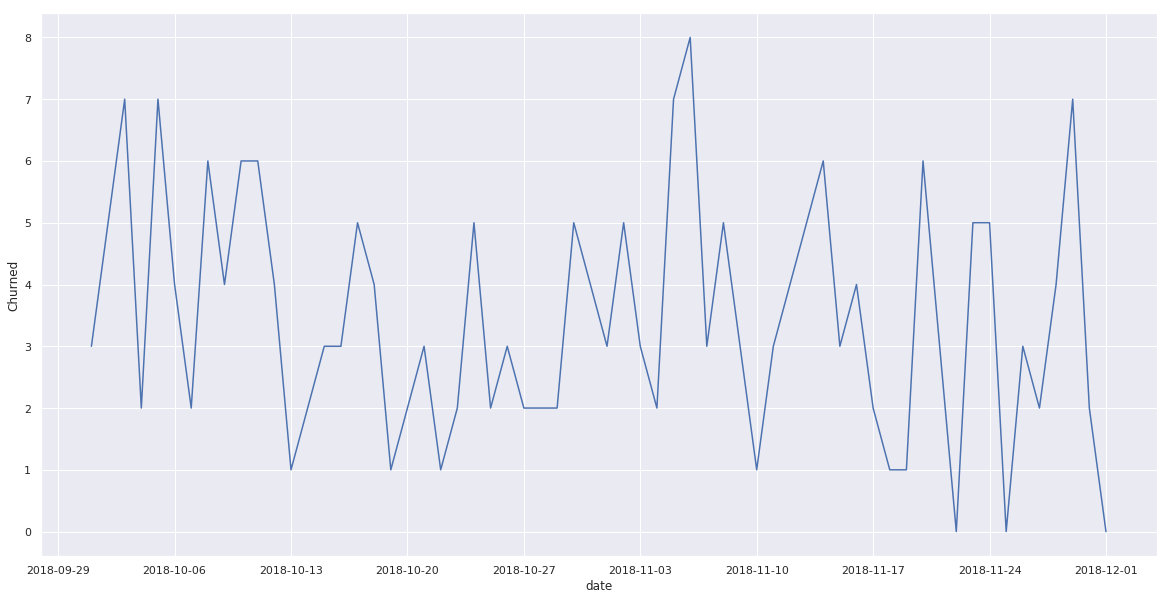

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
sns.lineplot(x="date", y="Churned",data=number_churn_per_day_pd);

# 3. Data preparation


In [27]:
churn_date_per_user = user_log.filter('Churned == 1').groupBy('userId').agg(F.min('date').alias('Churned_date'))

In [28]:
user_log_with_churnind = user_log.join(churn_date_per_user,on='userId', how='left')

In [29]:
user_log_with_churnind.take(1)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11))]

In [30]:
user_log_with_churnind.createTempView('user_log_with_churnind')

In [31]:
user_log_with_churnind = spark.sql('''SELECT *, 
            CASE WHEN Churned_date IS NULL then '2018-12-01'
            ELSE Churned_date END as Ref_date
            FROM user_log_with_churnind
            ''')

In [32]:
#Check results

user_log_with_churnind.groupBy('userId').agg(F.max('Churned'),F.min('ref_date')).show()

+------+------------+-------------+
|userId|max(Churned)|min(ref_date)|
+------+------------+-------------+
|100010|           1|   2018-10-11|
|200002|           1|   2018-10-30|
|   296|           1|   2018-10-10|
|   125|           0|   2018-12-01|
|   124|           1|   2018-11-11|
|    51|           1|   2018-10-16|
|     7|           0|   2018-12-01|
|200037|           1|   2018-10-24|
|   169|           0|   2018-12-01|
|   205|           0|   2018-12-01|
|   272|           0|   2018-12-01|
|    15|           0|   2018-12-01|
|   232|           1|   2018-11-02|
|   234|           1|   2018-11-01|
|   282|           0|   2018-12-01|
|    54|           1|   2018-10-08|
|   155|           0|   2018-12-01|
|200043|           0|   2018-12-01|
|100014|           1|   2018-10-21|
|   132|           1|   2018-10-08|
+------+------------+-------------+
only showing top 20 rows



In [33]:
observation_period = user_log_with_churnind.filter('date <= ref_date')

In [34]:
observation_period.count()

451874

In [35]:
observation_period = observation_period.withColumn('length_relationship', F.datediff(F.col('ref_date'),F.col('registration_date'))/365.25*12)


In [36]:
observation_period.describe('length_relationship').show()

+-------+-------------------+
|summary|length_relationship|
+-------+-------------------+
|  count|             436174|
|   mean|  2.753162022476758|
| stddev| 1.1569620615695195|
|    min|                0.0|
|    max| 12.845995893223819|
+-------+-------------------+



In [37]:
categories = observation_period.select("page").distinct().rdd.flatMap(lambda x: x).collect()

In [38]:
exprs = [F.when(F.col("page") == category, 1).otherwise(0).alias(category)
         for category in categories]

In [39]:
observation_period = observation_period.select('*', *exprs).withColumn('week',F.weekofyear('date'))

In [40]:
observation_period.take(3)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11), Ref_date='2018-10-11', length_relationship=0.45995893223819295, Cancel=0, Submit Downgrade=0, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, Cancellation Confirmation=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=0, Add Friend=0, NextSong=1, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0, week=41),
 Row(userId='100010', auth='Log

In [41]:
observation_period.columns

['userId',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'status',
 'ts',
 'userAgent',
 'date',
 'registration_date',
 'Churned',
 'Churned_date',
 'Ref_date',
 'length_relationship',
 'Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'week']

In [42]:
exprs = [F.sum(cat).alias(cat)  for cat in categories]

In [43]:
total_number_interactions_week = observation_period.groupBy(['userId','week']).agg(*exprs)

In [44]:
total_number_interactions_week.select(F.max('week')).show()

+---------+
|max(week)|
+---------+
|       48|
+---------+



In [45]:
tot_num_interactions_last_week = total_number_interactions_week.filter('week == 48')

In [46]:
total_number_interactions_week.take(3)

[Row(userId='100010', week=41, Cancel=1, Submit Downgrade=0, Thumbs Down=3, Home=3, Downgrade=0, Roll Advert=22, Logout=1, Save Settings=0, Cancellation Confirmation=1, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=1, Add Friend=3, NextSong=96, Thumbs Up=4, Help=0, Upgrade=2, Error=0, Submit Upgrade=0),
 Row(userId='200002', week=40, Cancel=0, Submit Downgrade=0, Thumbs Down=1, Home=7, Downgrade=0, Roll Advert=6, Logout=4, Save Settings=0, Cancellation Confirmation=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=1, Add Friend=2, NextSong=82, Thumbs Up=4, Help=0, Upgrade=1, Error=0, Submit Upgrade=0),
 Row(userId='200002', week=41, Cancel=0, Submit Downgrade=0, Thumbs Down=1, Home=10, Downgrade=1, Roll Advert=5, Logout=3, Save Settings=0, Cancellation Confirmation=0, About=1, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=3, Add Friend=0, NextSong=123, Thumbs Up=8, Help=1, Upgrade=1, Error=0,

In [47]:
exprs = [F.mean(cat).alias('Average number of ' + cat)  for cat in categories]

In [48]:
exprs

[Column<b'avg(Cancel) AS `Average number of Cancel`'>,
 Column<b'avg(Submit Downgrade) AS `Average number of Submit Downgrade`'>,
 Column<b'avg(Thumbs Down) AS `Average number of Thumbs Down`'>,
 Column<b'avg(Home) AS `Average number of Home`'>,
 Column<b'avg(Downgrade) AS `Average number of Downgrade`'>,
 Column<b'avg(Roll Advert) AS `Average number of Roll Advert`'>,
 Column<b'avg(Logout) AS `Average number of Logout`'>,
 Column<b'avg(Save Settings) AS `Average number of Save Settings`'>,
 Column<b'avg(Cancellation Confirmation) AS `Average number of Cancellation Confirmation`'>,
 Column<b'avg(About) AS `Average number of About`'>,
 Column<b'avg(Submit Registration) AS `Average number of Submit Registration`'>,
 Column<b'avg(Settings) AS `Average number of Settings`'>,
 Column<b'avg(Login) AS `Average number of Login`'>,
 Column<b'avg(Register) AS `Average number of Register`'>,
 Column<b'avg(Add to Playlist) AS `Average number of Add to Playlist`'>,
 Column<b'avg(Add Friend) AS `Ave

In [49]:
total_avg_interactions = total_number_interactions_week.groupBy('userId').agg(*exprs)

In [50]:
total_avg_interactions.take(3)

[Row(userId='100010', Average number of Cancel=1.0, Average number of Submit Downgrade=0.0, Average number of Thumbs Down=3.0, Average number of Home=3.0, Average number of Downgrade=0.0, Average number of Roll Advert=22.0, Average number of Logout=1.0, Average number of Save Settings=0.0, Average number of Cancellation Confirmation=1.0, Average number of About=0.0, Average number of Submit Registration=0.0, Average number of Settings=0.0, Average number of Login=0.0, Average number of Register=0.0, Average number of Add to Playlist=1.0, Average number of Add Friend=3.0, Average number of NextSong=96.0, Average number of Thumbs Up=4.0, Average number of Help=0.0, Average number of Upgrade=2.0, Average number of Error=0.0, Average number of Submit Upgrade=0.0),
 Row(userId='200002', Average number of Cancel=0.3333333333333333, Average number of Submit Downgrade=0.0, Average number of Thumbs Down=1.6666666666666667, Average number of Home=7.666666666666667, Average number of Downgrade=1.

In [51]:
observation_period = (observation_period
                      .withColumn('last_7_days', F.when(F.col('date') >= F.date_sub(F.col('ref_date'),7),1)
                      .otherwise(0)))

In [52]:
observation_period.take(3)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11), Ref_date='2018-10-11', length_relationship=0.45995893223819295, Cancel=0, Submit Downgrade=0, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, Cancellation Confirmation=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=0, Add Friend=0, NextSong=1, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0, week=41, last_7_days=1),
 Row(userId='100

In [53]:
exprs = [F.sum(cat).alias('Number ' + cat + ' last 7 days')  for cat in categories]

In [54]:
total_number_interactions_last7days = observation_period.where('last_7_days==1').groupBy('userId').agg(*exprs)

In [55]:
total_number_interactions_last7days.count()

338

In [56]:
demographics = observation_period.select(['userId', 'gender','location','length_relationship']).distinct()

In [57]:
demographics.count()

449

In [58]:
demographics.show(truncate=False,vertical=True)

-RECORD 0----------------------------------------------------
 userId              | 100010                                
 gender              | F                                     
 location            | Bridgeport-Stamford-Norwalk, CT       
 length_relationship | 0.45995893223819295                   
-RECORD 1----------------------------------------------------
 userId              | 200002                                
 gender              | M                                     
 location            | Chicago-Naperville-Elgin, IL-IN-WI    
 length_relationship | 1.7741273100616017                    
-RECORD 2----------------------------------------------------
 userId              | 296                                   
 gender              | F                                     
 location            | Allentown-Bethlehem-Easton, PA-NJ     
 length_relationship | 0.8542094455852156                    
-RECORD 3----------------------------------------------------
 userId 

In [59]:
demographics = demographics.withColumn('State', F.split(F.split(F.col('location'),',')[1],'-')[0])

In [60]:
demographics.show(truncate=False)

+------+------+-------------------------------------+-------------------+-----+
|userId|gender|location                             |length_relationship|State|
+------+------+-------------------------------------+-------------------+-----+
|100010|F     |Bridgeport-Stamford-Norwalk, CT      |0.45995893223819295| CT  |
|200002|M     |Chicago-Naperville-Elgin, IL-IN-WI   |1.7741273100616017 | IL  |
|296   |F     |Allentown-Bethlehem-Easton, PA-NJ    |0.8542094455852156 | PA  |
|125   |M     |Corpus Christi, TX                   |4.008213552361396  | TX  |
|124   |F     |Vineland-Bridgeton, NJ               |3.6796714579055436 | NJ  |
|51    |M     |Lexington-Fayette, KY                |0.6242299794661191 | KY  |
|7     |M     |Seattle-Tacoma-Bellevue, WA          |2.661190965092403  | WA  |
|200037|M     |Columbus, GA-AL                      |1.4127310061601643 | GA  |
|169   |M     |Lafayette-West Lafayette, IN         |2.628336755646817  | IN  |
|205   |F     |Ottawa-Peru, IL          

In [61]:
demographics.groupBy('State').count().show()

+-----+-----+
|State|count|
+-----+-----+
|   ME|    1|
|   WA|   10|
|   AL|    9|
|   NM|    3|
|   MI|   11|
|   HI|    1|
|   VT|    1|
|   MO|    8|
|   NE|    2|
| null|    1|
|   RI|    5|
|   NH|    3|
|   AK|    2|
|   AR|    2|
|   AZ|   10|
|   WV|    2|
|   TN|    9|
|   MA|    8|
|   NY|   36|
|   MD|    5|
+-----+-----+
only showing top 20 rows



In [62]:
churn_by_user.count()

449

In [63]:
# Join all the data together

combined_df = (demographics.join(tot_num_interactions_last_week,on='userId', how='left')
               .join(total_avg_interactions,on='userId', how='left')
               .join(churn_by_user,on='userId', how='left')
              )


In [64]:
combined_df.columns

['userId',
 'gender',
 'location',
 'length_relationship',
 'State',
 'week',
 'Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Average number of Cancel',
 'Average number of Submit Downgrade',
 'Average number of Thumbs Down',
 'Average number of Home',
 'Average number of Downgrade',
 'Average number of Roll Advert',
 'Average number of Logout',
 'Average number of Save Settings',
 'Average number of Cancellation Confirmation',
 'Average number of About',
 'Average number of Submit Registration',
 'Average number of Settings',
 'Average number of Login',
 'Average number of Register',
 'Average number of Add to Playlist',
 'Average number of Add Friend',
 'Average number of NextSong',
 'Average number of Thum

In [65]:
combined_df = combined_df.drop(*['Average number of Cancel','Average number of Submit Downgrade',
                                 'Average number of Cancellation Confirmation',
                                'Cancel','Submit Downgrade','Cancellation Confirmation','week','location'])

In [66]:
categories

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [67]:
# Create some ratio variables

base_vars = [cat for cat in categories if cat not in ['Cancel','Submit Downgrade','Cancellation Confirmation']]
compare_vars = ['Average number of ' + cat for cat in base_vars]

In [68]:
exprs = [(F.col(var)/F.col(var_i)).alias(var + ' ratio')  for var,var_i in zip(base_vars,compare_vars)]

In [69]:
exprs

[Column<b'(Thumbs Down / Average number of Thumbs Down) AS `Thumbs Down ratio`'>,
 Column<b'(Home / Average number of Home) AS `Home ratio`'>,
 Column<b'(Downgrade / Average number of Downgrade) AS `Downgrade ratio`'>,
 Column<b'(Roll Advert / Average number of Roll Advert) AS `Roll Advert ratio`'>,
 Column<b'(Logout / Average number of Logout) AS `Logout ratio`'>,
 Column<b'(Save Settings / Average number of Save Settings) AS `Save Settings ratio`'>,
 Column<b'(About / Average number of About) AS `About ratio`'>,
 Column<b'(Submit Registration / Average number of Submit Registration) AS `Submit Registration ratio`'>,
 Column<b'(Settings / Average number of Settings) AS `Settings ratio`'>,
 Column<b'(Login / Average number of Login) AS `Login ratio`'>,
 Column<b'(Register / Average number of Register) AS `Register ratio`'>,
 Column<b'(Add to Playlist / Average number of Add to Playlist) AS `Add to Playlist ratio`'>,
 Column<b'(Add Friend / Average number of Add Friend) AS `Add Friend r

In [70]:
combined_df = combined_df.select('*', *exprs)
    

In [71]:
combined_df.columns

['userId',
 'gender',
 'length_relationship',
 'State',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Average number of Thumbs Down',
 'Average number of Home',
 'Average number of Downgrade',
 'Average number of Roll Advert',
 'Average number of Logout',
 'Average number of Save Settings',
 'Average number of About',
 'Average number of Submit Registration',
 'Average number of Settings',
 'Average number of Login',
 'Average number of Register',
 'Average number of Add to Playlist',
 'Average number of Add Friend',
 'Average number of NextSong',
 'Average number of Thumbs Up',
 'Average number of Help',
 'Average number of Upgrade',
 'Average number of Error',
 'Average number of Submit Upgrade',
 'Churned',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 

In [72]:
check_results = combined_df.describe().toPandas()

In [73]:
check_results

,summary,userId,gender,length_relationship,State,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,Login ratio,Register ratio,Add to Playlist ratio,Add Friend ratio,NextSong ratio,Thumbs Up ratio,Help ratio,Upgrade ratio,Error ratio,Submit Upgrade ratio
0,count,449,448,448,448,166,166,166,166,166,...,1,1,161,159,165,164,147,122,107,90
1,mean,67520.34821428571,None,2.720445878556763,None,1.4698795180722892,10.295180722891565,1.355421686746988,1.572289156626506,1.9216867469879517,...,0.700715355182166,0.0,0.9796683120311976,0.9302567459323453,0.9848818552970979,0.9860640008611656,0.7887033023354141,0.4217922787594918,1.0548342234089898,0.8333333333333334
2,stddev,105964.5842848519,None,1.3415759529799054,None,2.058757197320107,51.77822966791062,1.894217869267975,3.377853478459704,2.2210861766955694,...,NaN,NaN,0.9975632234367202,1.1729846353910938,0.8450489841631038,0.8976633689779056,1.437785806229514,1.240757000692484,2.2283412486404295,2.3619169514174834
3,min,,F,0.0,AK,0,0,0,0,0,...,0.700715355182166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,99,M,12.845995893223819,WV,14,669,7,19,13,...,0.700715355182166,0.0,5.5,7.0,4.643063583815029,4.509090909090909,9.0,7.0,9.0,9.0


Lastly we need to impute the missing values. The following stategy would be used:
* For the categorical variables, we will impute the value 'Missing''
* For lenght of relationship, we will impute the value 999
* For the interaction variables and ratio variables, well impute the value 0. This is fine in this instance since if the interaction is missing, it means there was 0 interactions

In [74]:
combined_df.columns

['userId',
 'gender',
 'length_relationship',
 'State',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Average number of Thumbs Down',
 'Average number of Home',
 'Average number of Downgrade',
 'Average number of Roll Advert',
 'Average number of Logout',
 'Average number of Save Settings',
 'Average number of About',
 'Average number of Submit Registration',
 'Average number of Settings',
 'Average number of Login',
 'Average number of Register',
 'Average number of Add to Playlist',
 'Average number of Add Friend',
 'Average number of NextSong',
 'Average number of Thumbs Up',
 'Average number of Help',
 'Average number of Upgrade',
 'Average number of Error',
 'Average number of Submit Upgrade',
 'Churned',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 

In [75]:
combined_df.dtypes

[('userId', 'string'),
 ('gender', 'string'),
 ('length_relationship', 'double'),
 ('State', 'string'),
 ('Thumbs Down', 'bigint'),
 ('Home', 'bigint'),
 ('Downgrade', 'bigint'),
 ('Roll Advert', 'bigint'),
 ('Logout', 'bigint'),
 ('Save Settings', 'bigint'),
 ('About', 'bigint'),
 ('Submit Registration', 'bigint'),
 ('Settings', 'bigint'),
 ('Login', 'bigint'),
 ('Register', 'bigint'),
 ('Add to Playlist', 'bigint'),
 ('Add Friend', 'bigint'),
 ('NextSong', 'bigint'),
 ('Thumbs Up', 'bigint'),
 ('Help', 'bigint'),
 ('Upgrade', 'bigint'),
 ('Error', 'bigint'),
 ('Submit Upgrade', 'bigint'),
 ('Average number of Thumbs Down', 'double'),
 ('Average number of Home', 'double'),
 ('Average number of Downgrade', 'double'),
 ('Average number of Roll Advert', 'double'),
 ('Average number of Logout', 'double'),
 ('Average number of Save Settings', 'double'),
 ('Average number of About', 'double'),
 ('Average number of Submit Registration', 'double'),
 ('Average number of Settings', 'double'),
 

In [76]:
interaction_vars = combined_df.columns[4:23] + combined_df.columns[-19:]

In [77]:
interaction_vars

['Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 'Roll Advert ratio',
 'Logout ratio',
 'Save Settings ratio',
 'About ratio',
 'Submit Registration ratio',
 'Settings ratio',
 'Login ratio',
 'Register ratio',
 'Add to Playlist ratio',
 'Add Friend ratio',
 'NextSong ratio',
 'Thumbs Up ratio',
 'Help ratio',
 'Upgrade ratio',
 'Error ratio',
 'Submit Upgrade ratio']

In [78]:
combined_df = combined_df.na.fill(value='Missing',subset=['gender','State'])
combined_df = combined_df.na.fill(value=999,subset=['length_relationship'])
combined_df = combined_df.na.fill(value=0,subset=interaction_vars)

In [ ]:
combined_df.describe().show()

# 4. Modelling 

In [ ]:
# Splitting datset into train and test sets
combined_df.cache()
train, test = combined_df.randomSplit([0.8,0.2],seed=8989)

In [ ]:
train.select(F.mean('Churned')).show()

In [ ]:
test.select(F.sum('Churned')).show()

In [ ]:
feature_columns = train.columns

In [ ]:
feature_columns = ['gender_ohe',
 'length_relationship',
 'state_ohe',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 'Roll Advert ratio',
 'Logout ratio',
 'Save Settings ratio',
 'About ratio',
 'Submit Registration ratio',
 'Settings ratio',
 'Login ratio',
 'Register ratio',
 'Add to Playlist ratio',
 'Add Friend ratio',
 'NextSong ratio',
 'Thumbs Up ratio',
 'Help ratio',
 'Upgrade ratio',
 'Error ratio',
 'Submit Upgrade ratio'] 

In [ ]:
# Creating pipeline

gender_indexer = StringIndexer(inputCol='gender', outputCol='gender_index',handleInvalid='keep')
state_indexer = StringIndexer(inputCol='State', outputCol='state_index',handleInvalid='keep')
ohe_gender = OneHotEncoderEstimator(inputCols=['gender_index'],outputCols=['gender_ohe'],dropLast=False)  
ohe_state = OneHotEncoderEstimator(inputCols=['state_index'],outputCols=['state_ohe'] ,dropLast=False)  
vectorizer = VectorAssembler(inputCols=feature_columns,outputCol='features' )
rf_model = RandomForestClassifier(featuresCol='features', labelCol='Churned')

In [ ]:
pipeline = Pipeline(stages=[gender_indexer,state_indexer,ohe_gender,ohe_state,vectorizer,rf_model])

In [ ]:
# Fitting pipeline
rf_fitted = pipeline.fit(train)

In [ ]:
results = rf_fitted.transform(test)

In [ ]:
eval_roc = BinaryClassificationEvaluator(labelCol='Churned')

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Churned')

In [ ]:
print('Area under ROC: {}'.format(eval_roc.evaluate(results)))
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('Precision: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "weightedPrecision"})))
print('Recall: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "weightedRecall"})))
print('F1: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))
        

In [ ]:
bgt_model = GBTClassifier(featuresCol='features', labelCol='Churned',maxDepth=3,subsamplingRate=0.5,minInstancesPerNode=10)

In [ ]:
pipeline2 = Pipeline(stages=[gender_indexer,state_indexer,ohe_gender,ohe_state,vectorizer,bgt_model])

In [ ]:
# Fitting pipeline
gbt_fitted = pipeline2.fit(train)

In [ ]:
results = gbt_fitted.transform(test)

In [ ]:
print('Area under ROC: {}'.format(eval_roc.evaluate(results)))
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('Precision: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "weightedPrecision"})))
print('Recall: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "weightedRecall"})))
print('F1: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))
   

We see that the Gradient Boosting tree outpreforms the Random Forest, so next we'll tune the hyperparameters

In [ ]:
 param_grid = (ParamGridBuilder()
               .addGrid(bgt_model.maxDepth, [2, 3, 5]) 
               .addGrid(bgt_model.minInstancesPerNode, [10,15,20]) 
               .addGrid(bgt_model.maxIter, [20,30,40,50]) 
               .build())

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Churned',metricName='f1')

In [ ]:
gridsearch = CrossValidator(estimator=pipeline2,estimatorParamMaps=param_grid,numFolds=3,evaluator=evaluator,)

In [ ]:
cvmodel = gridsearch.fit(train)

In [ ]:
best_model = cvmodel.best_model

In [ ]:
save(name = 'GBT model',
     model = best_model,
     test_data = test,
     algorithm_type = 'Grandient Boosting tree',
     description='Implementation of a GBT algorithm on the Sparkify data to predict churn')


# 5. Results evaluation

In [ ]:
cvmodel